In [54]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import os

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [106]:
#参数设置
batchsz = 128
z_dim = 100
learning_rate = 1e-4
is_training = True
epochs = 30000
sample_count=4
network_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\模型输出\\GAN\\"
img_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\out\\"
if not os.path.exists(img_path):
    os.makedirs(img_path)

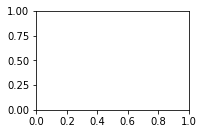

In [90]:
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0, 0])

In [91]:
#该函数用于输出生成图片
def plot(samples, sample_count=sample_count):
    fig = plt.figure(figsize=(sample_count, sample_count))
    gs = gridspec.GridSpec(sample_count, sample_count)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(tf.reshape(sample*255.,(28, 28)), cmap='Greys_r')

    return fig

In [92]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense1 = keras.layers.Dense(128)
        self.dense2 = keras.layers.Dense(784)
    @tf.function
    def call(self, inputs, training=None):
        g_1 = tf.nn.relu(self.dense1(inputs))
        g_logit = self.dense2(g_1)
        g = tf.nn.sigmoid(g_logit)
        return g

class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dense1 = keras.layers.Dense(128)
        self.dense2 = keras.layers.Dense(1)
    @tf.function
    def call(self, inputs, training=None):
        d_1 = tf.nn.relu(self.dense1(inputs))
        d_logit = self.dense2(d_1)
        #真(=1)，假(=0)
        d_prob = tf.nn.sigmoid(d_logit)
        return d_prob, d_logit

In [102]:
def sample_z(m, n):
    return tf.random.uniform(maxval=1., minval=-1., shape=[m, n])

In [95]:
# keras.datasets.mnist.load_data()输出类型为tuple->array，tuple结构（2，2）
# x结构为(60000,28,28),y结构为(60000,),dtype为uint8
# x结构为(10000,28,28),y结构为(10000,),dtype为uint8
(x, y),(x_val,y_val) = keras.datasets.mnist.load_data()

x = tf.convert_to_tensor(x, dtype=tf.float32)/255.
x = tf.reshape(x,(-1, 28*28))
y = tf.convert_to_tensor(y, dtype=tf.int32)
y_onehot = tf.one_hot(y, depth=10) # one_hot成立
train_dataset = tf.data.Dataset.from_tensor_slices((x,y)).repeat(-1).batch(batchsz)
train_dbiter = iter(train_dataset)

In [96]:
generator = Generator()
generator.build(input_shape=(None, z_dim))
discriminator = Discriminator()
discriminator.build(input_shape=(None, 784))

g_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [97]:
# 原始判别器和生成器损失
def d_loss_fn(generator, discriminator, batch_z, batch_x, is_training):
    fake_data = generator(batch_z, is_training)
    d_real,d_logit = discriminator(batch_x, is_training)
    d_fake,d_logit = discriminator(fake_data, is_training)
    d_loss = -tf.reduce_mean(tf.math.log(d_real) + tf.math.log(1. - d_fake))
    return d_loss
def g_loss_fn(generator, discriminator, batch_z, is_training):
    fake_data = generator(batch_z, is_training)
    d_fake,d_logit = discriminator(fake_data, is_training)
    g_loss = -tf.reduce_mean(tf.math.log(d_fake))
    return g_loss

In [98]:
# # 交叉熵损失函数
# def celoss_ones(logits):
#     loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=tf.ones_like(logits))
#     return tf.reduce_mean(loss)


# def celoss_zeros(logits):
#     loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.zeros_like(logits))
#     return tf.reduce_mean(loss)

# def d_loss_fn(generator, discriminator, batch_z, batch_x, is_training):
#     fake_data = generator(batch_z, is_training)
#     d_real,d_real_logits = discriminator(batch_x, is_training)
#     d_fake,d_fake_logits = discriminator(fake_data, is_training)
#     d_loss_real = celoss_ones(d_real_logits)
#     d_loss_fake = celoss_zeros(d_fake_logits)
#     d_loss = d_loss_fake + d_loss_real
#     return d_loss
# def g_loss_fn(generator, discriminator, batch_z, is_training):
#     fake_data = generator(batch_z, is_training)
#     d_fake,d_fake_logits = discriminator(fake_data, is_training)
#     g_loss = celoss_ones(d_fake_logits)
#     return g_loss

In [105]:
def save_image(label, generator, m=sample_count**2, n=z_dim):
    z = sample_z(m, n)
    fake_images = generator(z)
    fig = plot(fake_images)
    plt.savefig(img_path + "{}.png".format(label),bbox_inches="tight")
    plt.close(fig)

In [109]:
def save_weights_(generator, discriminator, network_path=network_path):
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    generator.save_weights(network_path+"cgan_g")
    discriminator.save_weights(network_path+"cgan_d")
    print("saved total weights.")

In [110]:

# for step, (batch_x, batch_y) in enumerate(train_dataset):
#     batch_z = sample_z(batchsz, z_dim)
for epoch in range(epochs+1):
    batch_z = sample_z(batchsz, z_dim)
    batch_x, batch_y = next(train_dbiter)
    
    with tf.GradientTape() as tape:
        d_loss = d_loss_fn(generator, discriminator, batch_z, batch_x, is_training)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    with tf.GradientTape() as tape:
        g_loss = g_loss_fn(generator, discriminator, batch_z, is_training)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    if epoch % 1000 == 0:
        save_image(str(epoch), generator)
        save_weights_(generator, discriminator)
        print(epoch, 'd-loss:', float(d_loss), 'g-loss:', float(g_loss))
        print()

saved total weights.
0 d-loss: 0.13402806222438812 g-loss: 3.2582359313964844

saved total weights.
1000 d-loss: 0.15404126048088074 g-loss: 3.390033721923828

saved total weights.
2000 d-loss: 0.17004743218421936 g-loss: 3.2146859169006348



In [112]:
# # 在custom layer中的 call() 上添加 @tf.function 可以将前向传播过程中不属于Graph的部分 转化为Graph。
# network_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\模型输出\\"
# generator.save_weights(network_path+"original_gan_g")
# discriminator.save_weights(network_path+"original_gan_d")
# print("saved total weights.")
del generator
del discriminator
generator = Generator()
discriminator = Discriminator()
save_image("载入前",generator)
generator.load_weights(network_path+"original_gan_g")
discriminator.load_weights(network_path+"original_gan_d")
save_image("载入后",generator)